In [1]:
# Change to Fork version of Pulser
import sys
sys.path.remove('/Users/seb/Documents/Projects/pasqal/Pulser')
sys.path.append('/Users/seb/Documents/Projects/pasqal/PulserFork/Pulser')

In [2]:
from pulser import Register, Pulse, Sequence, Simulation
from pulser.devices import Chadoq2
from pulser.waveforms import ConstantWaveform, RampWaveform

import numpy as np
import matplotlib.pyplot as plt
import qutip

## Single Atom

Prepare a single atom:

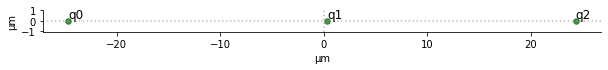

In [24]:
reg = Register.from_coordinates([(0,0), (25,0), (49,0)], prefix='q')
reg.draw()

Act on this atom with a Constant Pulse (a $2\pi$-pulse), such that it oscillates towards the excited Rydberg state and back to the original state:

In [25]:
seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0', 'rydberg_local', 'q0')

pulse = Pulse.ConstantPulse(10000, 2*np.pi*.5, 0.*2*np.pi, 0)
seq.add(pulse, 'ch0')

In [26]:
sim = Simulation(seq, sampling_rate=0.02)
res = sim.run()

In [27]:
obs = qutip.tensor(qutip.basis(2,0).proj(), qutip.qeye(2), qutip.qeye(2)) # |r><r|

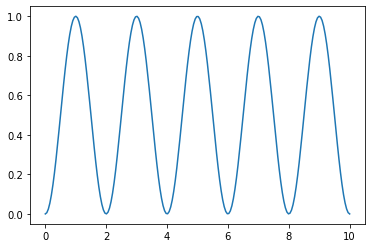

In [28]:
clean = res.expect([obs])[0]
plt.plot(sim._times, clean)

Now add SPAM errors to the simulation:

In [29]:
sim.add_noise('SPAM')

In [30]:
sim._noise

{'SPAM': True}

In [44]:
sim.spam_dict

{'eta': 0.005, 'epsilon': 0.01, 'epsilon_prime': 0.05}

In [31]:
sim.show_config()

{'initial_state': Quantum object: dims = [[2, 2, 2], [1, 1, 1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]], 'eval_t': -1, 'runs': 1, 'samples_per_run': 10}


In [38]:
sim.config('samples_per_run', 100)

In [39]:
res = sim.run()

The new `res` instance has similar methods to the usual `SimResults` object. For example, we can calculate expectation values:

In [40]:
res.expect([obs])[0]

0.02

Notice that by default the answer corresponds only to the final state of the evolution. To study the full-time dynamics with error, we indicate a specific time in the evolution with the parameter `t`.

Let us now create a function that evaluates noisy evolution for the entire time list of the simulation, and which can accept also a dictionary of SPAM parameters, `spam_dict`:

In [41]:
# Store original time list:
t_list = sim._times

In [42]:
def spam_evolution():
    occup = []
    for time in t_list:
        res = sim.run(eval_t=[0, time])
        occup.append(res.expect([obs])[0])
    return occup

Compare both clean and noisy simulations for the defaul SPAM parameters (taken from PRA_ARTICLE SPAM errors characterization)

detune
detune


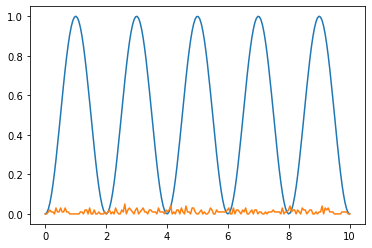

In [43]:
plt.plot(t_list, clean)
plt.plot(t_list, spam_evolution())

Change the *SPAM* dictionary:

In [31]:
def make_spam(eta=0.005, eps=0.01, eps_pr=0.05):
    return {"eta": eta, "epsilon": eps, "epsilon_prime": eps_pr}

In [32]:
res_spam = sim.run(spam=True, spam_dict=make_spam(eta=0.01))
res_spam.expect([obs])[0]

0.26641

### Changing $\eta$

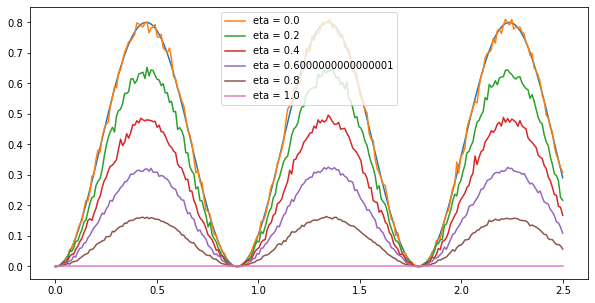

In [33]:
plt.figure(figsize=(10,5))
plt.plot(sim._times, clean)
for eta in np.linspace(0,1,6):
    plt.plot(sim._times, spam_evolution(spam_dict=make_spam(eta=eta, eps=0, eps_pr=0)), label=f'eta = {eta}')
plt.legend()

As $\eta$ grows, more qubits are not well-prepared and we stop seeing occupations at all.

### Changing $\epsilon$

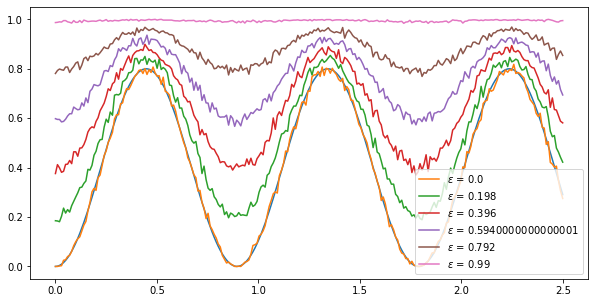

In [34]:
plt.figure(figsize=(10,5))
plt.plot(sim._times, clean)
for eps in np.linspace(0,.99,6):
    plt.plot(sim._times, spam_evolution(spam_dict=make_spam(eta=0, eps=eps, eps_pr=0)),
             label=rf'$\epsilon$ = {eps}')
plt.legend()

As more false negatives appear, it looks like the system is never captured, so always in a Rydberg state

### Changing $\epsilon'$

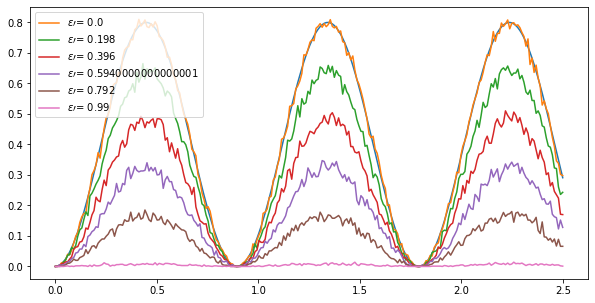

In [35]:
plt.figure(figsize=(10,5))
plt.plot(sim._times, clean)
for eps_pr in np.linspace(0,.99,6):
    plt.plot(sim._times, spam_evolution(spam_dict=make_spam(eta=0, eps=0, eps_pr=eps_pr)),
             label=rf'$\epsilon\prime$= {eps_pr}')
plt.legend()

As there are more false positives, all atoms seem to be recaptured, until no occupation is detected

## Doppler Noise

We can add Doppler Noise to our simulation with the `noise` kwargs:

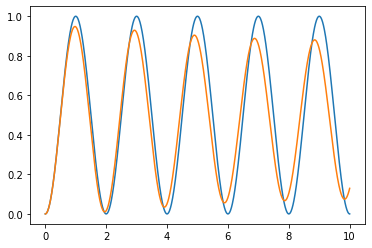

In [29]:
samples = 30
noisy_occupation = np.zeros(len(sim._times))

for _ in range(samples):
    noisy_sim = Simulation(seq, noise={'Doppler':True}, sampling_rate=0.1)
    noisy_res = noisy_sim.run()
    noisy_occupation += noisy_res.expect([obs])[0] / samples

plt.plot(sim._times, clean)
plt.plot(noisy_sim._times, noisy_occupation)

In [11]:
noisy_sim.samples['Global']['ground-rydberg']['amp']

array([2.55430297, 2.55430297, 2.55430297, ..., 2.55430297, 2.55430297,
       2.55430297])

## Multiple Atoms

We add the SPAM errors into the AFM state preparation sequence:

In [37]:
# Parameters in rad/µs and ns
Omega_max = 2.3 * 2*np.pi 
U = Omega_max / 2.3
delta_0 = -6 * U
delta_f = 2 * U
t_rise = 250
t_fall = 500
t_sweep = (delta_f - delta_0)/(2 * np.pi * 10) * 1000
R_interatomic = Chadoq2.rydberg_blockade_radius(U)

N_side = 3
reg = Register.rectangle(N_side, N_side, R_interatomic, prefix='q')

rise = Pulse.ConstantDetuning(RampWaveform(t_rise, 0., Omega_max), delta_0, 0.)
sweep = Pulse.ConstantAmplitude(Omega_max, RampWaveform(t_sweep, delta_0, delta_f), 0.)
fall = Pulse.ConstantDetuning(RampWaveform(t_fall, Omega_max, 0.), delta_f, 0.)

seq = Sequence(reg, Chadoq2)
seq.declare_channel('ising', 'rydberg_global')

seq.add(rise, 'ising')
seq.add(sweep, 'ising')
seq.add(fall, 'ising')


/Users/seb/Documents/Projects/pasqal/PulserFork/Pulser/pulser/utils.py:73: UserWarning: The given duration is below the machine's precision of 4 ns time steps. It was rounded down to the nearest multiple of 4 ns.
  warnings.warn("The given duration is below the machine's precision"


In [38]:

simul = Simulation(seq, sampling_rate=0.05)
clean_results = simul.run()
spam_results = simul.run(spam=True, noise={'Doppler':True})

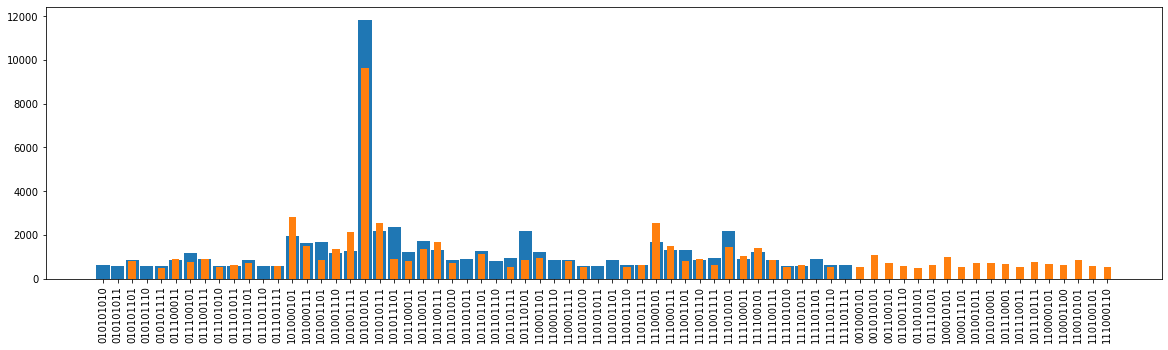

In [39]:
plt.figure(figsize=(20,5))

spam_count = spam_results.sample_final_state(meas_basis='ground-rydberg', N_samples=1e5)
clean_count = clean_results.sample_final_state(meas_basis='ground-rydberg', N_samples=1e5)

clean_most_freq = {k:v for k,v in clean_count.items() if v>500}
spam_most_freq = {k:v for k,v in spam_count.items() if v>500}

plt.bar(list(clean_most_freq.keys()), list(clean_most_freq.values()), width=0.9)
plt.bar(list(spam_most_freq.keys()), list(spam_most_freq.values()), width=0.5)

plt.xticks(rotation='vertical')
plt.show()